In [1]:
from xml.etree import ElementTree
import glob
from tensorflow import keras
import tensorflow as tf
import sklearn
from skimage import draw
from skimage.io import imshow, imread
from skimage import morphology
from skimage import transform
from skimage import util
import numpy as np
from matplotlib import pyplot
#from tensorflow import keras
#import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers, Model
from tensorflow.keras.utils import  plot_model
tf.keras.backend.set_image_data_format('channels_last')

2023-04-23 20:40:19.740709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 20:40:19.839614: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-23 20:40:19.842270: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-23 20:40:19.842279: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
et = ElementTree.parse("proboscis_annotations_big.xml")

In [3]:
image_names = sorted(glob.glob("big/*.png"))

In [4]:
masks = {}
for img in et.findall('image'):
    width = int(img.attrib['width']) + 1
    height = int(img.attrib['height']) + 1
    blank = np.zeros(shape=(height,width),dtype=np.uint8)
    polys = img.findall('polyline')
    for poly in polys:
        attribs = poly.attrib
        pstr = attribs['points']
        pairs = pstr.split(';')
        coord_list = []
        for pair in pairs:
            xstr,ystr = pair.split(',')
            x = float(xstr)
            y = float(ystr)
            coord_list.append((x,y))
        for i in range(len(coord_list) - 1):
            start = coord_list[i]
            end = coord_list[i + 1]
            line = draw.line(round(start[1]),round(start[0]),round(end[1]),round(end[0]))
            blank[line] = np.uint8(255)
    masks[img.attrib['name']] = blank

In [5]:
images = {}
for name in image_names:
    data = imread(name)
    images[name] = data

big/example0000000.png


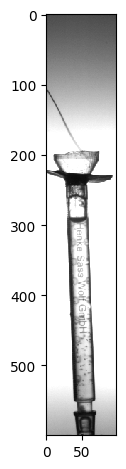

/home/tomas/.local/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


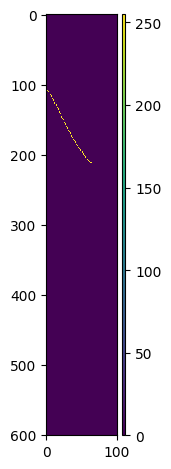

In [6]:
print(image_names[0])
imshow(images[image_names[0]])
pyplot.show()
imshow(masks[image_names[0]])
pyplot.show()

In [7]:
names = [image_name[4:] for image_name in image_names]

In [8]:
pairs = []
cross = zip(image_names, image_names)
for short_name, long_name in cross:
    if short_name in masks:
        mask = masks[short_name]
        trainee = images[long_name]
        pairs.append((trainee, morphology.dilation(mask[:-1,:-1])))
    else:
        trainee = images[long_name]
        mask = np.zeros(shape=trainee.shape)
        pairs.append((trainee, mask))

In [9]:
len(pairs)

373

(600, 100) (600, 100)


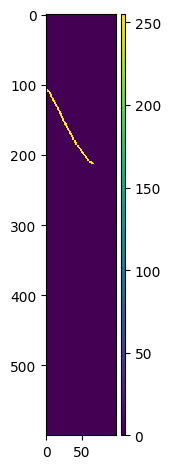

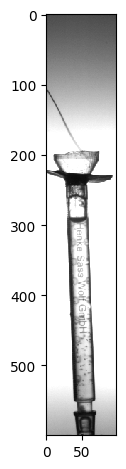

(600, 100) (600, 100)


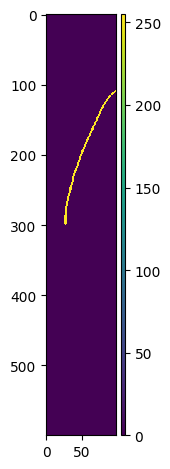

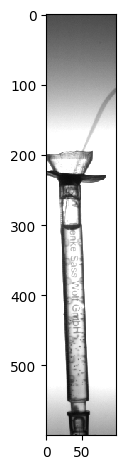

(600, 100) (600, 100)


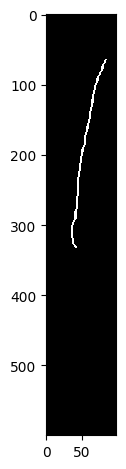

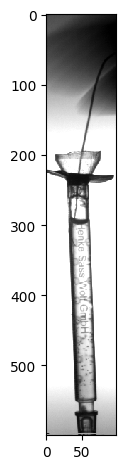

(600, 100) (600, 100)


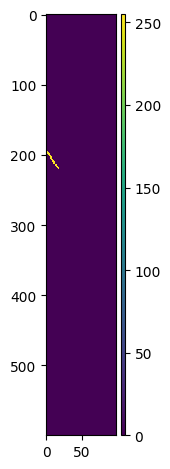

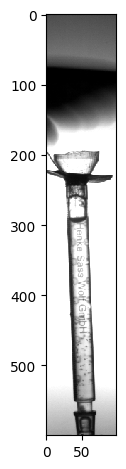

(600, 100) (600, 100)


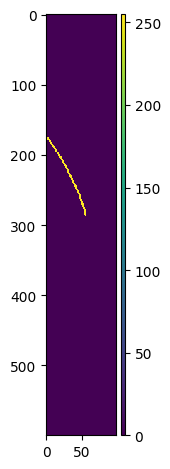

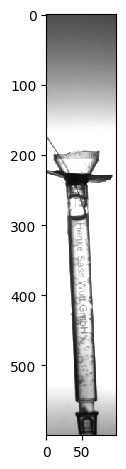

(600, 100) (600, 100)


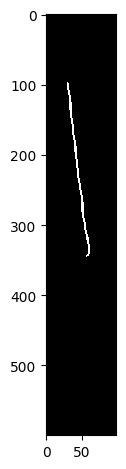

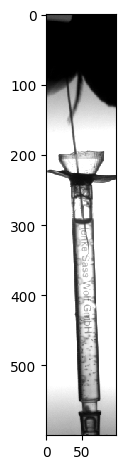

(600, 100) (600, 100)


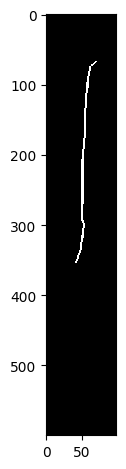

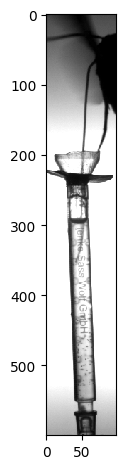

(600, 100) (600, 100)


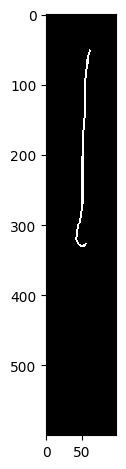

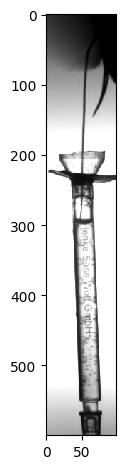

(600, 100) (600, 100)


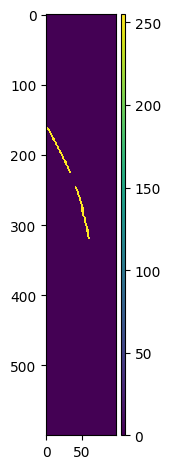

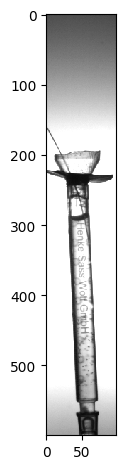

(600, 100) (600, 100)


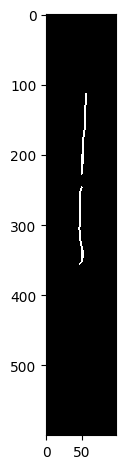

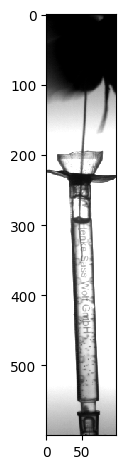

(600, 100) (600, 100)


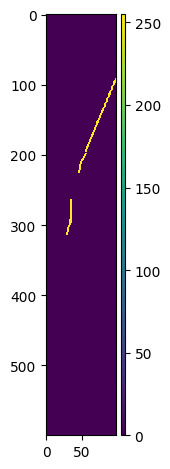

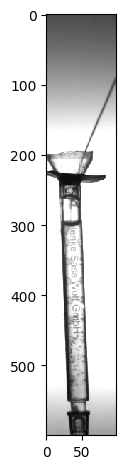

(600, 100) (600, 100)


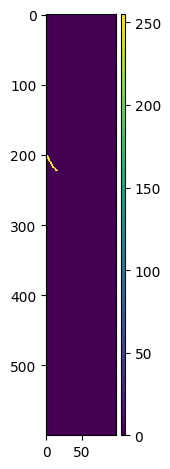

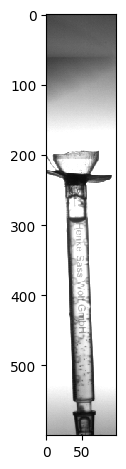

(600, 100) (600, 100)


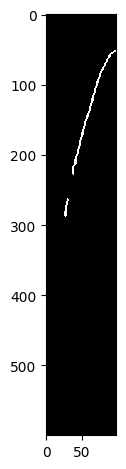

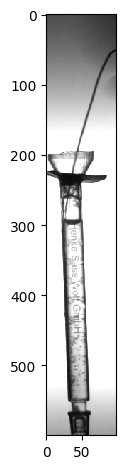

(600, 100) (600, 100)


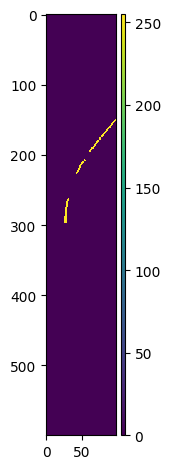

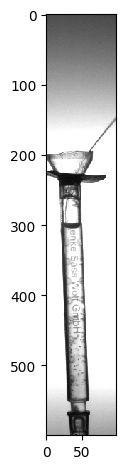

(600, 100) (600, 100)


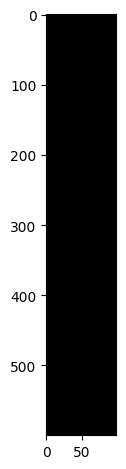

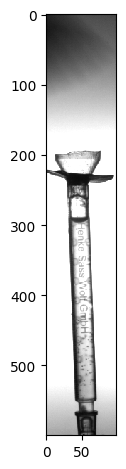

(600, 100) (600, 100)


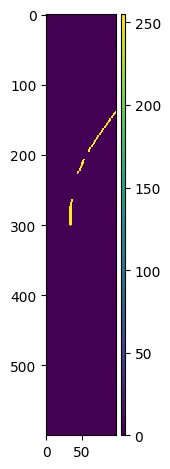

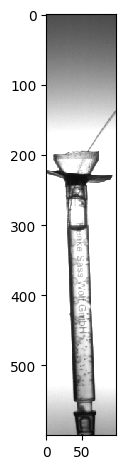

(600, 100) (600, 100)


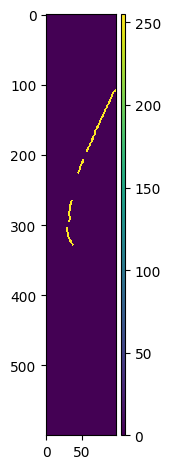

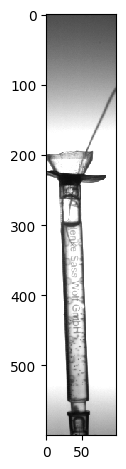

(600, 100) (600, 100)


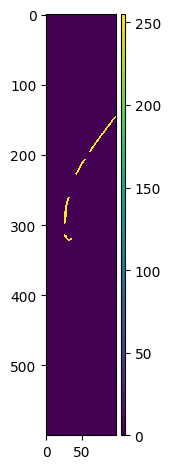

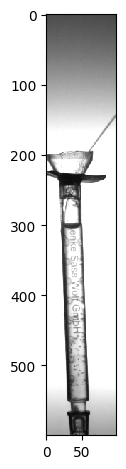

(600, 100) (600, 100)


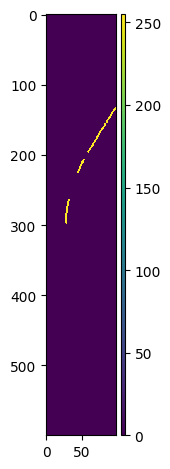

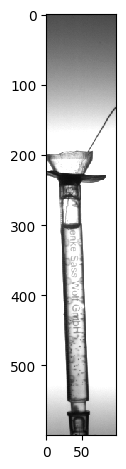

(600, 100) (600, 100)


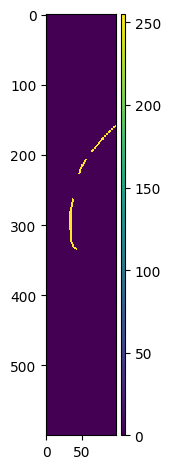

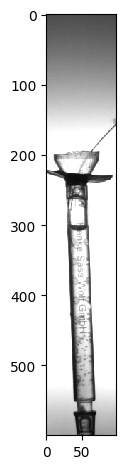

(600, 100) (600, 100)


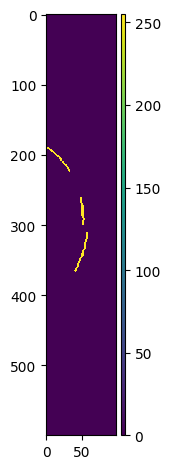

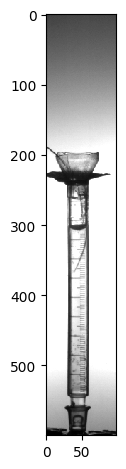

(600, 100) (600, 100)


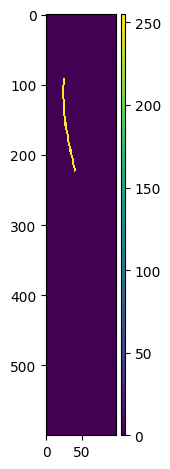

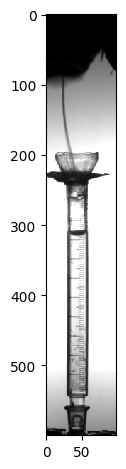

(600, 100) (600, 100)


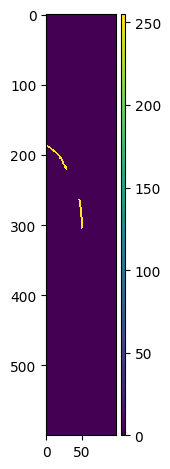

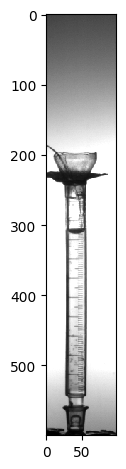

(600, 100) (600, 100)


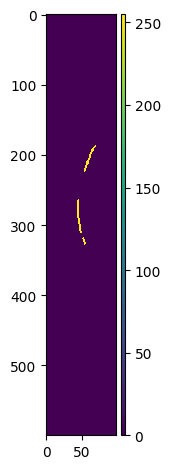

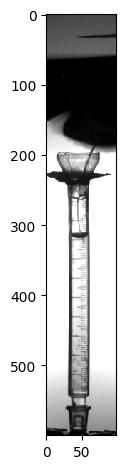

(600, 100) (600, 100)


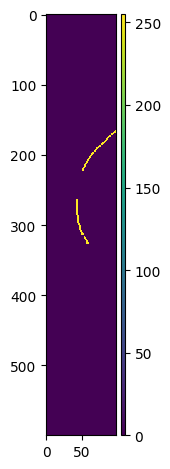

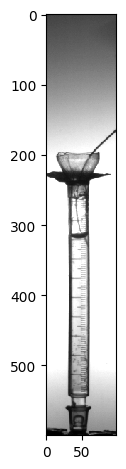

(600, 100) (600, 100)


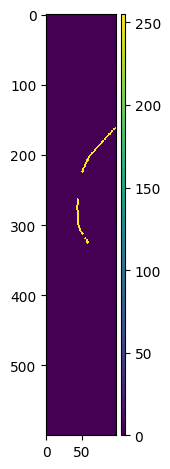

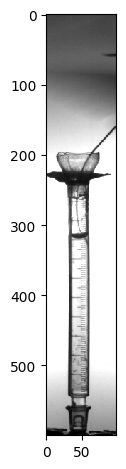

(600, 100) (600, 100)


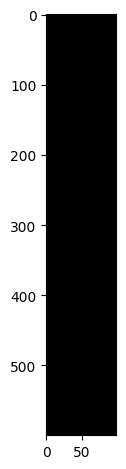

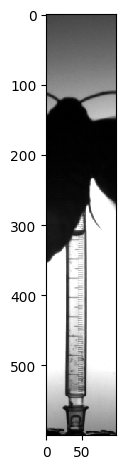

(600, 100) (600, 100)


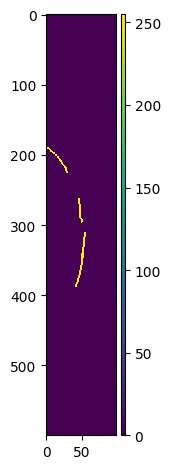

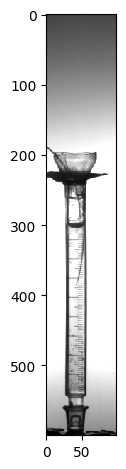

(600, 100) (600, 100)


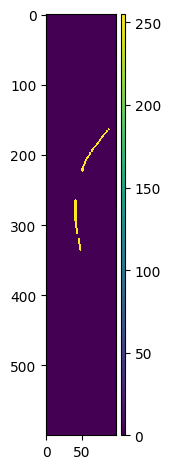

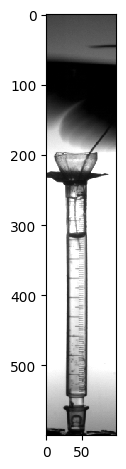

(600, 100) (600, 100)


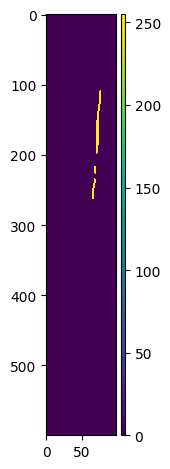

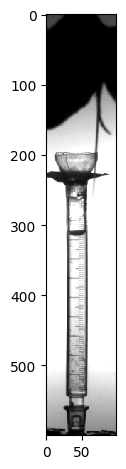

(600, 100) (600, 100)


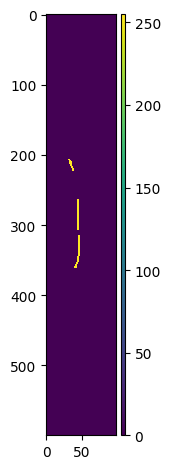

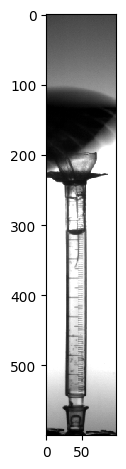

(600, 100) (600, 100)


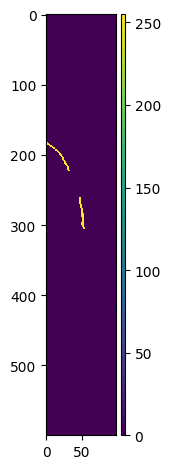

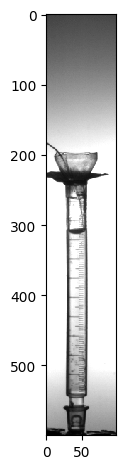

In [10]:
for i,p in enumerate(pairs):
    print(p[0].shape, p[1].shape)
    imshow(p[1])
    pyplot.show()
    imshow(p[0])
    pyplot.show()
    if i > 30:
        break

In [10]:
with_probs = filter(lambda pair : pair[1].sum() > 0, pairs)

In [11]:
labeled_pairs = list(with_probs)

In [12]:
len(labeled_pairs)

350

75

In [13]:
inputs = []
outputs = []
for my_in, my_out in labeled_pairs:
    inputs.append(my_in)
    outputs.append(my_out)

In [14]:
ins = np.array(inputs)
outs = np.array(outputs)

In [15]:
ins.shape

(350, 600, 100)

In [16]:
outs.shape

(350, 600, 100)

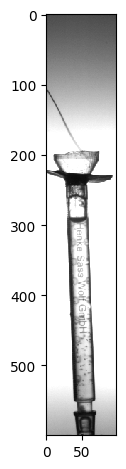

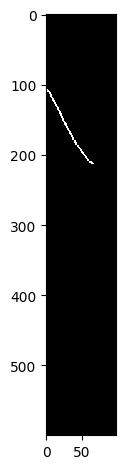

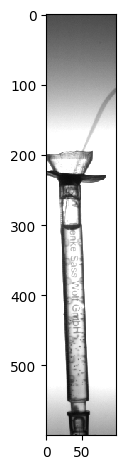

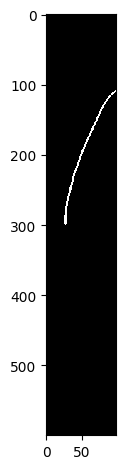

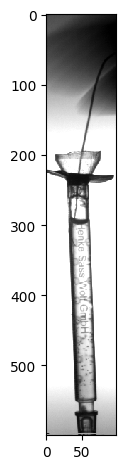

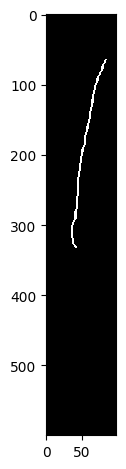

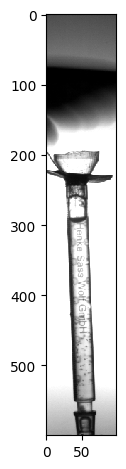

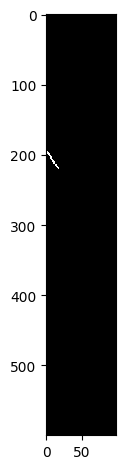

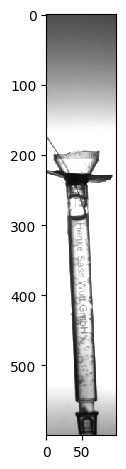

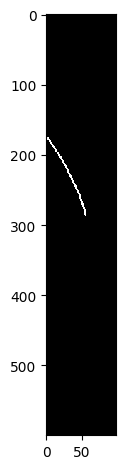

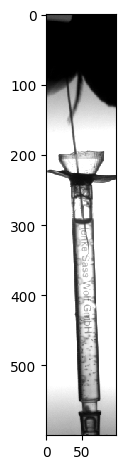

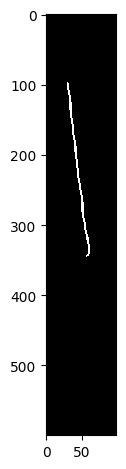

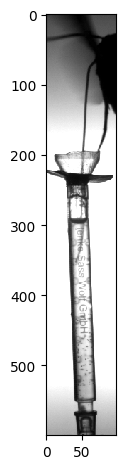

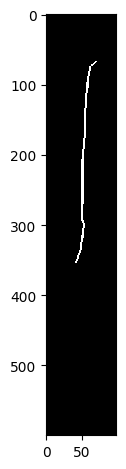

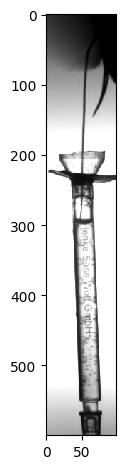

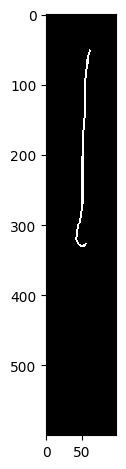

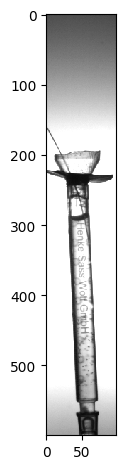

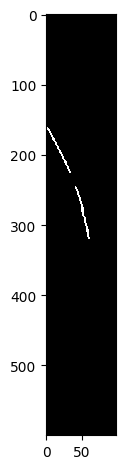

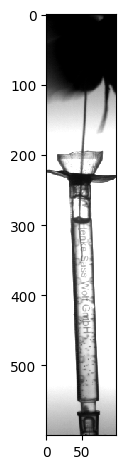

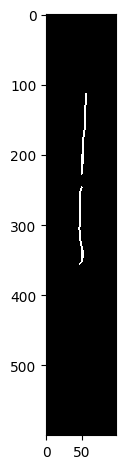

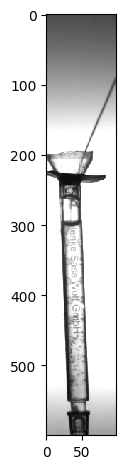

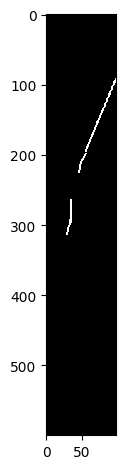

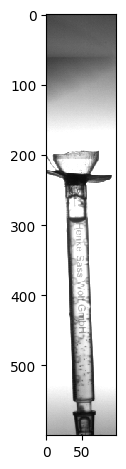

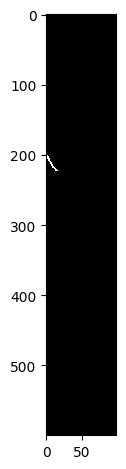

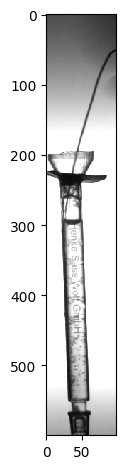

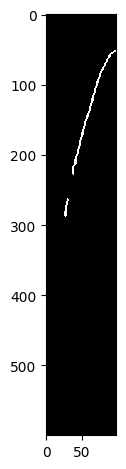

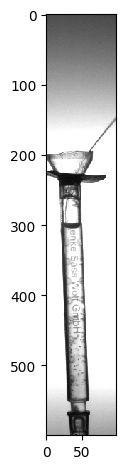

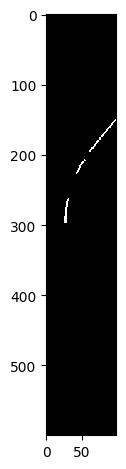

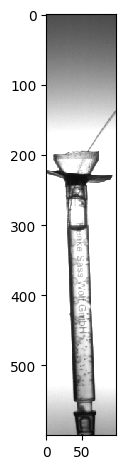

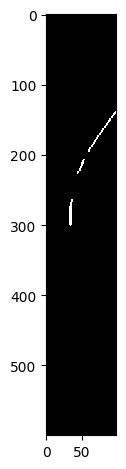

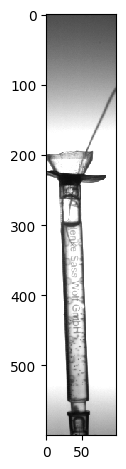

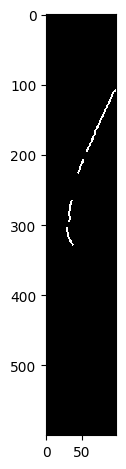

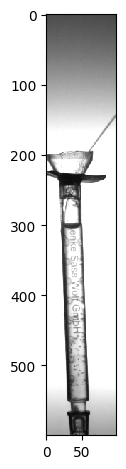

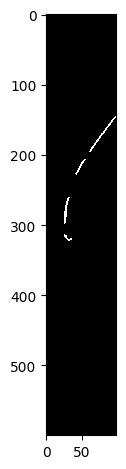

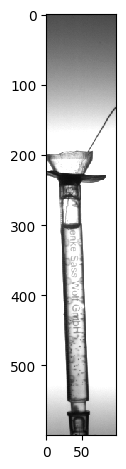

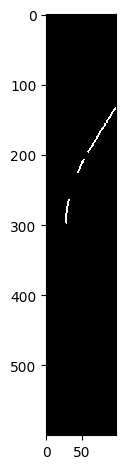

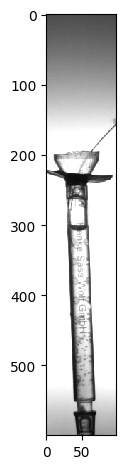

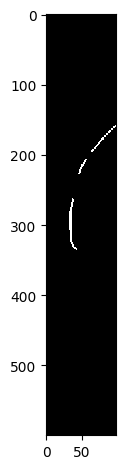

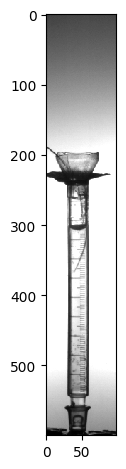

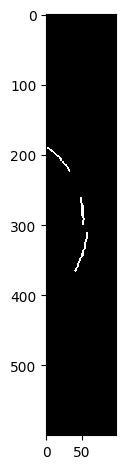

In [17]:
input_data = ins[...,np.newaxis]
output_data = outs[...,np.newaxis]
output_data = output_data != 0
for i in range(20):
    imshow(input_data[i,:,:,0])
    pyplot.show()
    imshow(output_data[i,:,:,0])
    pyplot.show()

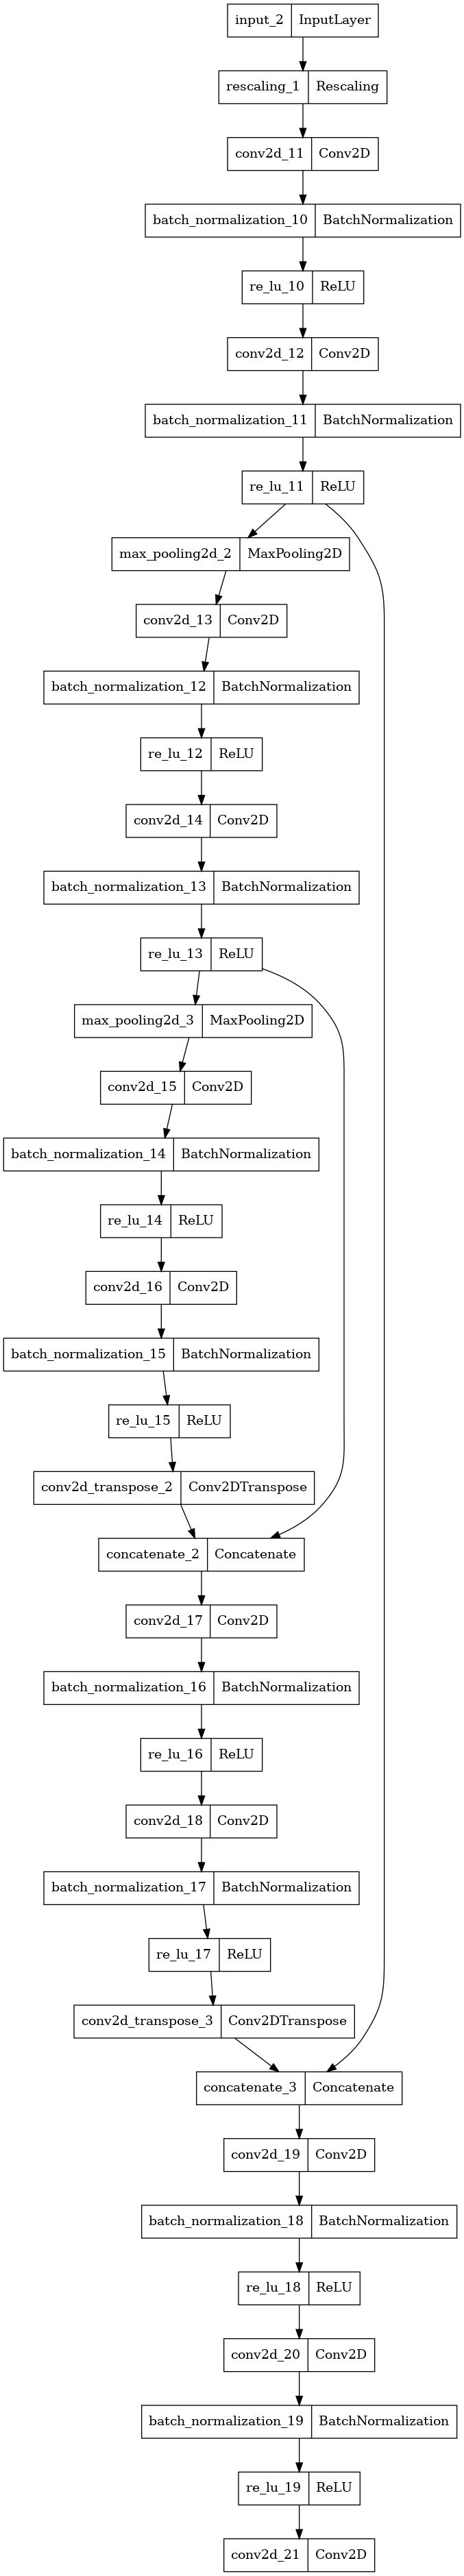

In [73]:
# from https://blog.paperspace.com/unet-architecture-image-segmentation/

def convolution_block(input_lay, filters=64):
    conv1 = layers.Conv2D(filters, kernel_size=(3,3), padding="same")(input_lay)
    bn1 = layers.BatchNormalization()(conv1)
    act1 = layers.ReLU()(bn1)
    
    conv2 = layers.Conv2D(filters, kernel_size=(3,3), padding="same")(act1)
    bn2 = layers.BatchNormalization()(conv2)
    act2 = layers.ReLU()(bn2)
    
    return act2

def encoder(input_lay, filters=64):
    enc1 = convolution_block(input_lay, filters)
    max_pool1 = layers.MaxPooling2D()(enc1)
    return enc1, max_pool1

def decoder(input_lay, skip_lay, filters=64):
    upsample = layers.Conv2DTranspose(filters, (2,2), strides=2, padding="same")(input_lay)
    connect_skip = layers.Concatenate()([upsample, skip_lay])
    out = convolution_block(connect_skip, filters)
    return out

def u_net(image_size):
    input1 = layers.Input(image_size)
    
    skip1, enc1 = encoder(input1, 64)
    skip2, enc2 = encoder(enc1, 64 * 2)
    skip3, enc3 = encoder(enc2, 64 * 4)
    skip4, enc4 = encoder(enc3, 64 * 8)
    
    conv_block = convolution_block(enc4, 64*16)
    
    dec1 = decoder(conv_block, skip4, 64 * 8)
    dec2 = decoder(dec1, skip3, 64 * 4)
    dec3 = decoder(dec2, skip2, 64 * 2)
    dec4 = decoder(dec3, skip1, 64)
    
    out = layers.Conv2D(filters=1, kernel_size=(1,1), padding="same", activation="sigmoid")(dec4)
    
    model = Model(input1, out)
    
    return model

inp = layers.Input(shape=[600,100,1])
res = layers.Rescaling(1.0/255)(inp)
#x = layers.Conv2D(filters=4, kernel_size=(3,3))(res)

skip1, enc1 = encoder(res, 64)
skip2, enc2 = encoder(enc1, 64 * 2)
#skip3, enc3 = encoder(enc2, 64 * 4)

conv_block = convolution_block(enc2, 64 * 4)

dec1 = decoder(conv_block, skip2, 64 * 2)
dec2 = decoder(dec1, skip1, 64)
#dec3 = decoder(dec2, skip1, 64)

f = layers.Flatten()(dec2)

#out = layers.Dense(1)(f)
out = layers.Conv2D(filters=1, kernel_size=(1,1))(dec2)

model = Model(inp, out)
model.compile(loss=losses.BinaryCrossentropy(), optimizer=optimizers.Adam(use_ema=True))
plot_model(model)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 600, 100, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 600, 100, 64  640         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

                                )                                                                 
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 300, 50, 128  512        ['conv2d_7[0][0]']               
 rmalization)                   )                                                                 
                                                                                                  
 re_lu_7 (ReLU)                 (None, 300, 50, 128  0           ['batch_normalization_7[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 600, 100, 64  32832      ['re_lu_7[0][0]']                
 spose)                         )                                                                 
          

In [18]:
import math

class ImageSeq(keras.utils.Sequence):
    
    def __init__(self, ins: np.ndarray, outs: np.ndarray, batch=32):
        assert ins.shape == outs.shape
        self.inputs = np.copy(ins)
        self.outputs = np.copy(outs)
        self.batch = batch
    
    def __len__(self):
        return math.ceil(len(self.inputs) / self.batch)
    
    def __getitem__(self, idx):
        i = self.inputs[idx * self.batch : (idx + 1) * self.batch]
        o = self.outputs[idx * self.batch : (idx + 1) * self.batch]
        return i.astype(np.uint8), o
    

class RepeatSeq(keras.utils.Sequence):
    
    def __init__(self, wrapped, repeats :int):
        self.wrapped = wrapped
        self.repeats = repeats
    
    def __len__(self):
        return len(self.wrapped) * self.repeats
    
    def __getitem__(self, idx):
        rel_idx = idx % len(self.wrapped)
        i, o = self.wrapped[rel_idx]
        return np.copy(i), np.copy(o)
    
class RandomFlip(keras.utils.Sequence):
    
    def __init__(self, wrapped, thresh=0.4):
        self.wrapped = wrapped
        self.thresh = thresh
        self.should_flip = np.random.random(len(wrapped))
    
    def __len__(self):
        return len(self.wrapped)
    
    def __getitem__(self, idx):
        i, o = self.wrapped[idx]
        give_i = i[:]
        give_o = o[:]
        if self.should_flip[idx] > self.thresh:
            give_i = np.flip(give_i, axis=1)
            give_o = np.flip(give_o, axis=1)
        return give_i, give_o

class RandomXShift(keras.utils.Sequence):
    
    def __init__(self, wrapped, thresh=0.4):
        self.wrapped = wrapped
        self.move_likely = np.random.random(len(wrapped))
        self.thresh = thresh
        self.move_amount = np.random.randint(-20, 20, len(wrapped))
    
    def __len__(self):
        return len(self.wrapped)
    
    def __getitem__(self, idx):
        i, o = self.wrapped[idx]
        give_i = i[:]
        give_o = o[:]
        if self.move_likely[idx] > self.thresh:
            move = self.move_amount[idx]
            transl = transform.EuclideanTransform(translation=[move, 0])
            for j in range(len(give_i)):
                give_i[j] = util.img_as_ubyte(transform.warp(give_i[j], transl.inverse))
                give_o[j] = util.img_as_ubyte(transform.warp(give_o[j], transl.inverse))
        return give_i, give_o

class RandomYShift(keras.utils.Sequence):
    
    def __init__(self, wrapped, thresh=0.4):
        self.wrapped = wrapped
        self.move_likely = np.random.random(len(wrapped))
        self.thresh = thresh
        self.move_amount = np.random.randint(-200, 200, len(wrapped))
    
    def __len__(self):
        return len(self.wrapped)
    
    def __getitem__(self, idx):
        i, o = self.wrapped[idx]
        give_i = i[:]
        give_o = o[:]
        if self.move_likely[idx] > self.thresh:
            move = self.move_amount[idx]
            transl = transform.EuclideanTransform(translation=[0, move])
            for j in range(len(give_i)):
                give_i[j] = util.img_as_ubyte(transform.warp(give_i[j], transl.inverse))
                give_o[j] = util.img_as_ubyte(transform.warp(give_o[j], transl.inverse))
        return give_i, give_o

In [19]:
r = RandomXShift(RandomYShift(RandomFlip(RepeatSeq(ImageSeq(input_data, output_data), 256))))

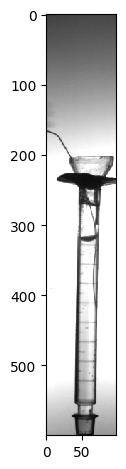

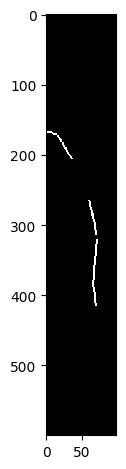

In [70]:
a,b = r[2000]
imshow(a[0,:,:,0])
pyplot.show()
imshow(b[0,:,:,0])
pyplot.show()

In [74]:
model.fit(r, epochs=20)

Epoch 1/20
2816/2816 [==============================] - 42486s 15s/step - loss: 0.0365
Epoch 2/20
1446/2816 [==============>...............] - ETA: 6:03:55 - loss: 0.0223

KeyboardInterrupt: 

In [20]:
ot1 = keras.models.load_model("overtrained_1")

2023-04-23 20:41:37.836796: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-23 20:41:37.836810: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-23 20:41:37.836820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Silicon-Eye): /proc/driver/nvidia/version does not exist
2023-04-23 20:41:37.837002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
from skimage import feature, measure

In [22]:
a, b = r[0]

In [23]:
sift = feature.SIFT()

In [43]:
in_fsets = []
out_objs = []

for i, img in enumerate(input_data):
    h_in = feature.hog(img[:,:,0])
    in_fsets.append(h_in)
    h_out = feature.hog(output_data[i,:,:,0])
    out_fsets.append(h_out)

In [47]:
from sklearn.feature_extraction.image import PatchExtractor
import random

In [54]:
shared_seed = random.randint(0, 10_000)
patch_extractor1 = PatchExtractor(patch_size=(20,20), max_patches=1500, random_state=shared_seed)
patch_extractor2 = PatchExtractor(patch_size=(20,20), max_patches=1500, random_state=shared_seed)
patches_input = patch_extractor1.transform(input_data)
patches_output = patch_extractor2.transform(output_data)
print(patches_input.shape)
print(patches_output.shape)

(525000, 20, 20)
(525000, 20, 20)


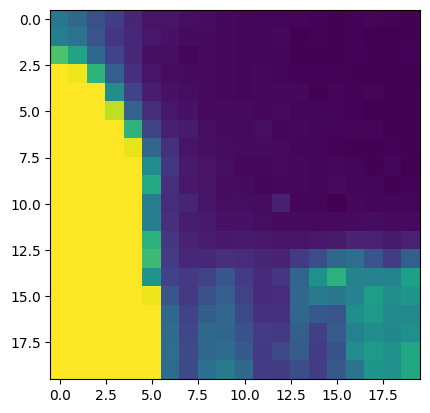

In [55]:
pyplot.imshow(patches_input[0])
pyplot.show()

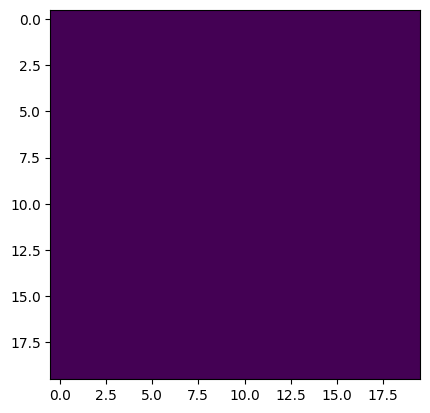

In [56]:
pyplot.imshow(patches_output[0])
pyplot.show()

In [60]:
positives = []
for p in patches_output:
    idents = np.argwhere(p)
    positives.append(idents)

array([], shape=(0, 2), dtype=int64)